In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skbio

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa   
from ete3 import Tree
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from skbio.stats.distance import anosim
from skbio.stats.distance import DistanceMatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.model_selection import train_test_split

# To send

1. alpha diversity: test results & plots
2. permanova results [optional]
3. PROCRUSTES results + Aitchinson distance
4. LMMs & Wilcoxon 

TESTS
1. ADONIS
2. KRUSKALL WALLIS ON ALPHA DIVERSITY
3. RANDOM FOREST WITH SHAP VALUES

In [2]:
relab_otu_df = pd.read_csv('data/lung_cancer_123_phylo_rare_otu.tsv', sep = '\t')
relab_sample_df = pd.read_csv('data/lung_cancer_123_phylo_rare_sample.tsv', sep = '\t')
relab_tax_df = pd.read_csv('data/lung_cancer_123_phylo_rare_tax.tsv', sep = '\t')

absolute_otu_df = pd.read_csv('data/lung_cancer_123_quant_otu.tsv', sep = '\t')
absolute_sample_df = pd.read_csv('data/lung_cancer_123_quant_sample.tsv', sep = '\t')
absolute_tax_df = pd.read_csv('data/lung_cancer_123_quant_tax.tsv', sep = '\t')

In [3]:
relab_otu_df.shape, absolute_otu_df.shape

((582, 96), (477, 69))

In [4]:
progression_dict = dict(zip(relab_sample_df.index, relab_sample_df['Progression.Yes.No']))
treatment_dict = dict(zip(relab_sample_df.index, relab_sample_df['Treatment']))
patient_dict = dict(zip(relab_sample_df.index, relab_sample_df['Patient']))

In [5]:
def get_patients_timepoints(metadata):
    
    'return patient id that have pre and post sample'
    
    patients_count = pd.DataFrame.\
                    from_dict(Counter(metadata.Patient), orient='index').\
                    reset_index().\
                    rename({"index":"patient", 0:"count"}, axis=1)
    
    keep_patients =  patients_count[patients_count['count'] == 2].patient.values
    keep_samples = metadata[metadata.Patient.isin(keep_patients)].index.values
    return keep_patients, keep_samples

relab_keep_patient, relab_keep_sample = get_patients_timepoints(relab_sample_df)
absolute_keep_patient, absolute_keep_sample = get_patients_timepoints(absolute_sample_df)

In [6]:
# Filter otu table 
relab_otu_df = relab_otu_df[relab_keep_sample]
relab_sample_df = relab_sample_df[relab_sample_df.index.isin(relab_keep_sample)] 

absolute_otu_df = absolute_otu_df[absolute_keep_sample]
absolute_sample_df = absolute_sample_df[absolute_sample_df.index.isin(absolute_keep_sample)] 

## Prepare data

In [7]:
#Collapse features on species level

def merge_on_species_level(df, tax_df):
    
    species_dict = dict(zip(tax_df.index, [specie.replace(' ', '_').replace(':', '_') for specie in tax_df.Species]))
    
    species_df = df.copy()
    species_df.index = species_df.index.map(species_dict)
    species_df = species_df.groupby(by = species_df.index).sum()
    
    return species_df

relab_species_df = merge_on_species_level(relab_otu_df, relab_tax_df)
absolute_species_df = merge_on_species_level(absolute_otu_df, absolute_tax_df)

In [8]:
relab_species_df.shape, absolute_species_df.shape

((473, 54), (416, 54))

## Filter low abundance data

In [9]:
def filter_prevalence(df, treshold = 0.1):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 0):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_relab_otu_df = filter_prevalence(relab_otu_df.T)
filtered_relab_species_df = filter_prevalence(relab_species_df.T)

filtered_absolute_otu_df = filter_prevalence(absolute_otu_df.T)
filtered_absolute_species_df = filter_prevalence(absolute_species_df.T)

In [10]:
filtered_relab_species_df.shape, filtered_absolute_species_df.shape

((54, 391), (54, 378))

In [11]:
# Prepare tree for phylogenetic analysis
def prepare_tree(tree_file, df, name):
    
    ete3_tree = Tree(tree_file, format=1)
    
    otu_ids = df.columns.tolist()
    ete3_tree.prune(otu_ids, True)
    ete3_tree.write(format=1, outfile=f"data/{name}_prunned_tree.nwk")
    
    # red into skbio 
    tree = skbio.TreeNode.read(f'data/{name}_prunned_tree.nwk')
    return tree

In [12]:
relab_tree = prepare_tree('data/lung_cancer_123_phylo_rare_tree.nwk', filtered_relab_otu_df, 'relab')
absolute_tree = prepare_tree('data/lung_cancer_123_quant_tree.nwk', filtered_absolute_otu_df, 'absolute')

## 1. 1. alpha diversity between datawith Kruskal Wallis and Wilcoxon tests

In [13]:
from skbio.diversity.alpha import faith_pd, shannon, chao1, pielou_e

In [14]:
def calculate_alpha_diversities(species_df, features_df, tree):
    
    shannon_df = species_df.apply(lambda x: shannon(x),axis=1)
    faith_pd_df = features_df.apply(lambda x: faith_pd(x, taxa = features_df.columns, tree=tree),axis=1)
    chao_df = species_df.apply(lambda x: chao1(x),axis=1)
    pielou_df = species_df.apply(lambda x: pielou_e(x),axis=1)
    
    alpha_diversity_df = pd.concat([shannon_df, faith_pd_df, chao_df, pielou_df], axis=1)
    alpha_diversity_df.columns = ['shannon', 'faith', 'chao', 'pielou']
    
    alpha_diversity_df['Progression'] = alpha_diversity_df.index.map(progression_dict)
    alpha_diversity_df['Treatment'] = alpha_diversity_df.index.map(treatment_dict)
    alpha_diversity_df['Patient'] = alpha_diversity_df.index.map(patient_dict)

    return alpha_diversity_df

In [15]:
relative_alpha_diversity = calculate_alpha_diversities(filtered_relab_species_df, filtered_relab_otu_df, relab_tree)
absolute_alpha_diversity = calculate_alpha_diversities(filtered_absolute_species_df, filtered_absolute_otu_df, absolute_tree)

In [16]:
Conditions1 = ['Yes', 'No']
Conditions2 = ['Pre', 'Post']

results = []
for cond1 in Conditions1:
    for cond2 in Conditions2:

        df1 = relative_alpha_diversity[(relative_alpha_diversity.Progression == cond1) & (relative_alpha_diversity.Treatment == cond2)]
        df2 = absolute_alpha_diversity[(absolute_alpha_diversity.Progression == cond1) & (absolute_alpha_diversity.Treatment == cond2)]
        
        diversity_metrics = ['shannon', 'faith', 'chao', 'pielou']
        
        for div in diversity_metrics:
            
            results.append({"cond1":cond1,
                            "cond2":cond2,
                            "measure":div,
                            "pvalue":stats.mannwhitneyu(df1[div], df2[div])[1]})

In [17]:
results_df = pd.DataFrame(results)
results_df['pvalue_adj'] = np.where(results_df.pvalue < 0.05, 1, 0)
results_df

,cond1,cond2,measure,pvalue,pvalue_adj
0,Yes,Pre,shannon,0.007661,1
1,Yes,Pre,faith,0.681618,0
2,Yes,Pre,chao,0.456894,0
3,Yes,Pre,pielou,0.010344,1
4,Yes,Post,shannon,0.504985,0
5,Yes,Post,faith,1.000000,0
6,Yes,Post,chao,0.877440,0
7,Yes,Post,pielou,0.383320,0
8,No,Pre,shannon,0.015854,1
9,No,Pre,faith,0.597223,0


In [18]:
for div in diversity_metrics:
    print(div, np.round(stats.mannwhitneyu(relative_alpha_diversity[div], absolute_alpha_diversity[div])[1], 3))

shannon 0.001
faith 0.756
chao 0.513
pielou 0.001


In [ ]:
# plot a scatterlot of alpha diversity; boxplot with lines between patients 

## 1.2 ANOSIM ON beta diversity distances

In [19]:
def calculate_WU(df, taxa, tree):
    
    num_samples = df.shape[0]
    unifrac_matrix = np.zeros((num_samples, num_samples))
    
    for i in range(num_samples):
        for j in range(i, num_samples):  # Start from i to compute only the upper triangle
            if i == j:
                unifrac_matrix[i, j] = 0  # Distance from a sample to itself is zero
            else:
                distance = weighted_unifrac(df.iloc[i], df.iloc[j], taxa=taxa, tree=tree)
                unifrac_matrix[i, j] = distance
                unifrac_matrix[j, i] = distance  # Symmetric matrix
    
    return unifrac_matrix

def calculate_UWU(df, taxa, tree):
    num_samples = df.shape[0]
    unifrac_matrix = np.zeros((num_samples, num_samples))
    
    for i in range(num_samples):
        for j in range(i, num_samples):  # Start from i to compute only the upper triangle
            if i == j:
                unifrac_matrix[i, j] = 0  # Distance from a sample to itself is zero
            else:
                distance = unweighted_unifrac(df.iloc[i], df.iloc[j], taxa=taxa, tree=tree)
                unifrac_matrix[i, j] = distance
                unifrac_matrix[j, i] = distance  # Symmetric matrix
    
    return unifrac_matrix

In [20]:
beta_relab_species_df = filtered_relab_species_df.copy()
beta_relab_species_df.index = ['relative']* len(beta_relab_species_df)

beta_absolute_species_df = filtered_absolute_species_df.copy()
beta_absolute_species_df.index = ['absolute']* len(beta_absolute_species_df)

BETA_SPECIES_DF = pd.concat([beta_relab_species_df, beta_absolute_species_df]).fillna(0)
grouping_variable = BETA_SPECIES_DF.index

In [21]:
def calculate_beta_matrices(input_df, tree):
    
    binary_df = input_df.copy()
    binary_df[binary_df>0]=1
    
    logE_M = squareform(pdist(np.log(input_df+1e-2)))
    BC_M = squareform(pdist(input_df,'braycurtis'))
    J_M = squareform(pdist(binary_df,'jaccard'))
    #WU_M = calculate_WU(input_df, input_df.columns, tree)
    #UWU_M = calculate_UWU(binary_df, input_df.columns, tree)
    
    return logE_M, BC_M, J_M#, WU_M, UWU_M

In [22]:
logE_M, BC_M, J_M = calculate_beta_matrices(BETA_SPECIES_DF, relab_tree)

In [23]:
dm = DistanceMatrix(logE_M)
anosim_res = anosim(dm, grouping_variable)
print(f'p-value: {anosim_res.loc["p-value"]}, stat: {anosim_res.loc["test statistic"]:.2f}')

p-value: 0.001, stat: 0.22


In [24]:
dm = DistanceMatrix(BC_M)
anosim_res = anosim(dm, grouping_variable)
print(f'p-value: {anosim_res.loc["p-value"]}, stat: {anosim_res.loc["test statistic"]:.2f}')

p-value: 0.001, stat: 0.87


In [25]:
dm = DistanceMatrix(J_M)
anosim_res = anosim(dm, grouping_variable)
print(f'p-value: {anosim_res.loc["p-value"]}, stat: {anosim_res.loc["test statistic"]:.2f}')

p-value: 0.524, stat: -0.00


# PROCRUSTES

In [26]:
def calculate_pcoa(species_input, otu_input, tree):
    
    #species_input = filtered_relab_species_df.copy()
    #otu_input = filtered_relab_otu_df.copy()

    WU_M = calculate_WU(otu_input, otu_input.columns, tree)

    logE_M = squareform(pdist(np.log(species_input+1e-2)))
    BC_M = squareform(pdist(species_input,'braycurtis'))

    binary_species = species_input.copy()
    binary_species[binary_species>0]=1
    J_M = squareform(pdist(binary_species,'jaccard'))

    binary_otu = otu_input.copy()
    binary_otu[binary_otu>0]=1
    UWU_M = calculate_UWU(binary_otu, binary_otu.columns, tree)

    return pcoa(WU_M).samples, pcoa(logE_M).samples, pcoa(BC_M).samples, pcoa(UWU_M).samples, pcoa(J_M).samples

In [27]:
pcoaWU_rel, pcoaE_rel, pcoaBC_rel, pcoaUWU_rel, pcoaJ_rel = calculate_pcoa(filtered_relab_species_df, filtered_relab_otu_df, relab_tree)
pcoaWU_abs, pcoaE_abs, pcoaBC_abs, pcoaUWU_abs, pcoaJ_abs = calculate_pcoa(filtered_absolute_species_df, filtered_absolute_otu_df, absolute_tree)

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.6531717156359312 and the largest is 9.709209570003395.
  warn(
/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section

In [28]:
from scipy.spatial import procrustes

# Add Aitchinson

WU1, WU2, WUdisp = procrustes(pcoaWU_rel, pcoaWU_abs)
UWU1, UWU2, UWUdisp = procrustes(pcoaUWU_rel, pcoaUWU_abs)
E1, E2, Edisp = procrustes(pcoaE_rel, pcoaE_abs)
BC1, BC2, BCdisp = procrustes(pcoaBC_rel, pcoaBC_abs)
J1, J2, Jdisp = procrustes(pcoaJ_rel, pcoaJ_abs)

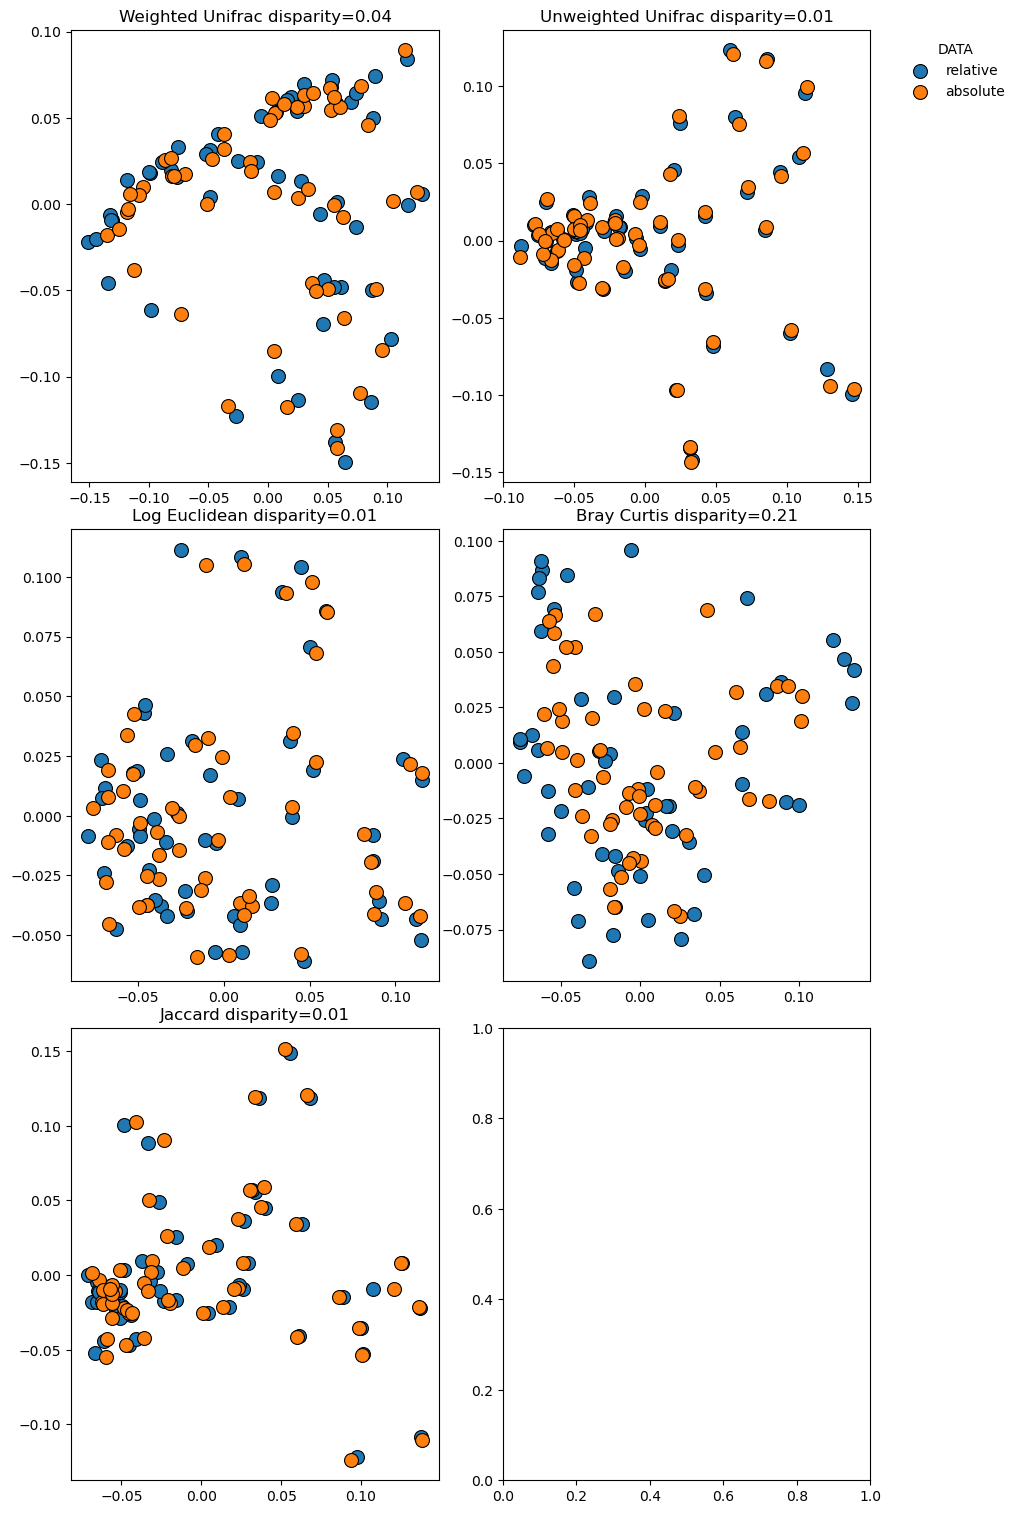

In [29]:
fig, axes = plt.subplots(3, 2, figsize = (10, 15))

sns.scatterplot(x = WU1[:, 0], y = WU1[:, 1], ax=axes[0, 0], s=100, edgecolor='k')
sns.scatterplot(x = WU2[:, 0], y = WU2[:, 1], ax=axes[0, 0], s=100, edgecolor='k')

sns.scatterplot(x = UWU1[:, 0], y = UWU1[:, 1], ax=axes[0, 1], label = 'relative', s=100, edgecolor='k')
sns.scatterplot(x = UWU2[:, 0], y = UWU2[:, 1], ax=axes[0, 1], label = 'absolute', s=100, edgecolor='k')

sns.scatterplot(x = E1[:, 0], y = E1[:, 1], ax=axes[1, 0], s=100, edgecolor='k')
sns.scatterplot(x = E2[:, 0], y = E2[:, 1], ax=axes[1, 0], s=100, edgecolor='k')

sns.scatterplot(x = BC1[:, 0], y = BC1[:, 1], ax=axes[1, 1], s=100, edgecolor='k')
sns.scatterplot(x = BC2[:, 0], y = BC2[:, 1], ax=axes[1, 1], s=100, edgecolor='k')

sns.scatterplot(x = J1[:, 0], y = J1[:, 1], ax=axes[2, 0], s=100, edgecolor='k')
sns.scatterplot(x = J2[:, 0], y = J2[:, 1], ax=axes[2, 0], s=100, edgecolor='k')

axes[0, 0].title.set_text(f'Weighted Unifrac disparity={WUdisp:.2f}')
axes[0, 1].title.set_text(f'Unweighted Unifrac disparity={UWUdisp:.2f}')
axes[1, 0].title.set_text(f'Log Euclidean disparity={Edisp:.2f}')
axes[1, 1].title.set_text(f'Bray Curtis disparity={BCdisp:.2f}')
axes[2, 0].title.set_text(f'Jaccard disparity={Jdisp:.2f}')

axes[0, 1].legend(bbox_to_anchor = (1.4, 1), edgecolor='w', title='DATA')

plt.tight_layout(pad = .2)
plt.savefig('procrustes.png', dpi=300)

## RANDOM FOREST

In [30]:
#filtered_relab_species_df, filtered_absolute_species_df

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, roc_auc_score, f1_score

In [32]:
def get_shap_values(shap_values, feature_names):
    
    shap_values_class_0 = shap_values[:, :, 0]
    mean_contributions_class_0 = np.mean(shap_values_class_0.values, axis=0)
    
    # Create a DataFrame to display the results
    mean_contribution_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean SHAP Contribution (Class 0)': mean_contributions_class_0
    })
    
    # Sort the DataFrame by mean contribution
    mean_contribution_df_sorted = mean_contribution_df.sort_values(by='Mean SHAP Contribution (Class 0)', ascending=False)
    
    return mean_contribution_df_sorted

In [33]:
def run_rf(df, relative = False):

    df = df[df.index.isin(relab_sample_df[relab_sample_df['Treatment'] == 'Pre'].index)]
    
    #Filter features with small variance
    var_df = df.var().sort_values()
    features = df.var().loc[lambda x: x > x.quantile(0.7)].index
    df = df[features]
    
    # Merge with metadata
    input_data = pd.concat([df, relab_sample_df[relab_sample_df.index.isin(df.index)][['Gender']]], axis=1)
    label_encoder = LabelEncoder()
    input_data['Gender'] = label_encoder.fit_transform(input_data['Gender'])
    
    X = input_data.values
    y = input_data.index.map(progression_dict).values
    y = [int(i.replace('Yes', '1').replace('No', '0')) for i in y]
    y = np.array(y)
    
    n_splits=20
    kf = StratifiedShuffleSplit(n_splits=n_splits, train_size=0.8, test_size=0.2, random_state=42)
    
    precision_scores = []
    recall_scores = []
    auc_scores = []
    f1_scores = []
    SHAP_VALUES = pd.DataFrame()
    results = []
    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):  # Start enumeration at 1
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        #scaler = StandardScaler()
        #X_train = scaler.fit_transform(X_train)
        #X_test = scaler.transform(X_test)
        
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf.fit(X_train, y_train)
    
        explainer = shap.Explainer(rf_clf, X_train)
        shap_values = explainer(X_test)
    
        shap_values_df = get_shap_values(shap_values, input_data.columns)
        shap_values_df['fold'] = fold
    
        # Score predictions
        y_pred = rf_clf.predict(X_test)
        y_prob = rf_clf.predict_proba(X_test)[:, 1]
        
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        

        SHAP_VALUES = pd.concat([SHAP_VALUES, shap_values_df])
        
        results.append({'precision':precision,
                        'recall':recall,
                        'auc_scores':auc,
                        'f1_scores':f1,
                        'fold':fold})
        
    results_df = pd.DataFrame(results)

    return results_df, SHAP_VALUES

In [34]:
rf_relative_res, rf_relative_shap =run_rf(np.log(filtered_relab_species_df.div(filtered_relab_species_df.sum(axis=1), axis=0)+1e-2), True) 
rf_absolute_res, rf_absolute_shap =run_rf(np.log(filtered_absolute_species_df.div(filtered_absolute_species_df.sum(axis=1), axis=0)+1e-2), True) 

In [35]:
rf_absolute_res['data'] = 'Absolute'
rf_relative_res['data'] = 'Relative'

<Axes: xlabel='data', ylabel='f1_scores'>

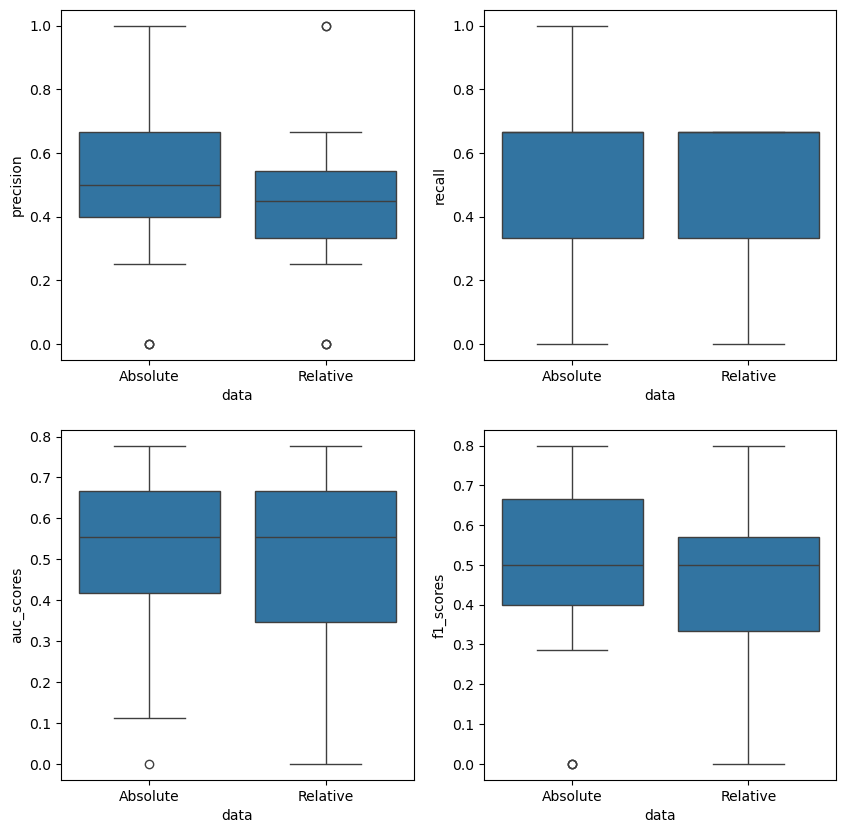

In [36]:
rf_results_df = pd.concat([rf_absolute_res, rf_relative_res])

fig, axes = plt.subplots(2,2, figsize = (10, 10))
sns.boxplot(data=rf_results_df, x = 'data', y = 'precision', ax=axes[0, 0])
sns.boxplot(data=rf_results_df, x = 'data', y = 'recall', ax=axes[0, 1])
sns.boxplot(data=rf_results_df, x = 'data', y = 'auc_scores', ax=axes[1, 0])
sns.boxplot(data=rf_results_df, x = 'data', y = 'f1_scores', ax=axes[1, 1])